# The Reflection Layer

The reflection layer uses [Householder reflections](https://en.wikipedia.org/wiki/Householder_transformation) to reflect its input about a reflection axis. A single reflection layer can to multiple reflections in succession which allows for rotation. Inputs are flattened along the shape input before reflection and unflattened afterwards. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Reflection.*

In [ ]:
# Import modules
#import warnings
#warnings.filterwarnings('ignore')
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl
from gyoza.modelling import flow_layers as mfl, masks as gmm, standard_layers as msl
from gyoza.tutorials import data_iterators as mdis, data_synthesis as gtd, plotting as gtp

from ipywidgets import interact, fixed
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Data Generation

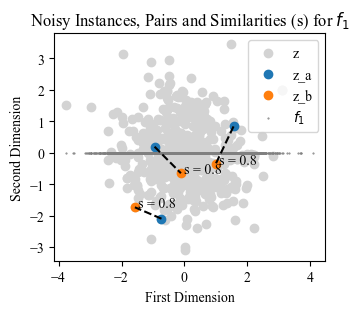

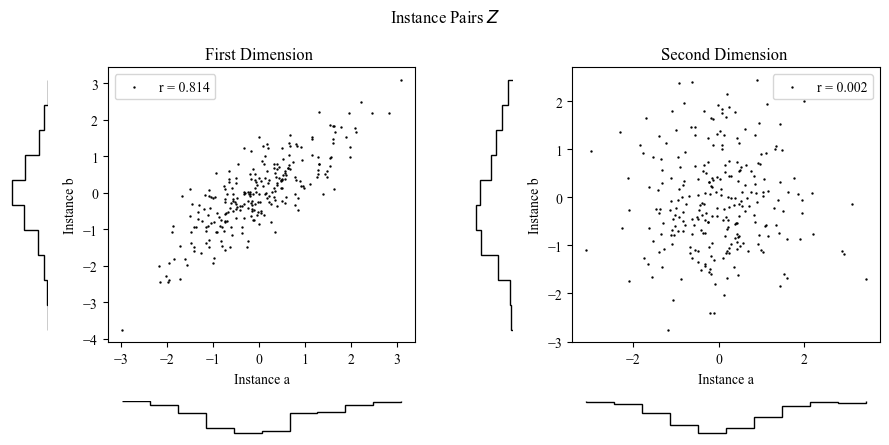

In [ ]:
manifold_name = 'f_1'

# Generate points along a line
M = 2**13; N = 2 # Instance count, dimension count
gtd.reset_random_number_generators(seed=3) # Reproducability
S = np.random.normal(loc=0, scale=1, size=[M])

# Set up the raw manifold function
manifold_function = lambda S: (S, np.zeros(len(S)))

# Generate a dataset
noise_standard_deviation = [0.0, 1.0]
Z, Y = gtd.create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**8
target_correlations = [0.0, 0.8]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
gtp.plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
gtp.plot_instance_pairs_2(Z_ab=Z_ab)

## Model Creation

Variable path:  reflection_1/reflection_normals
Variable value:  [[-0.367967   -0.92983885]]  (default initialization of dimension 0 and 1, respectively)


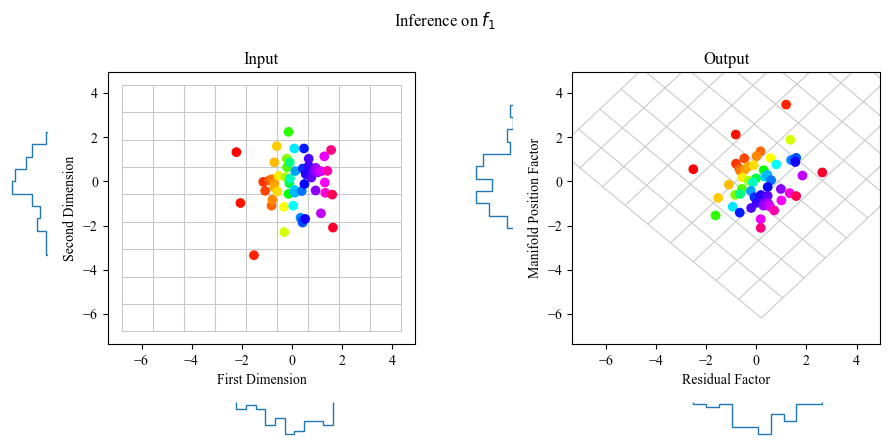

In [6]:
# Create network
def create_network():
    network = mfl.SupervisedFactorModel(layers=[mfl.Reflection(axes=[1], shape=[N], reflection_count=1)], dimensions_per_factor=[1,1], sigma=1.0)
    network.build() # Initialization of some layer parameters
    return network

gtd.reset_random_number_generators(seed=1) # Reproducability
network = create_network()

# Inspect scaling parameter
print("Variable path: ", network.trainable_variables[0].path)
print("Variable value: ", network.trainable_variables[0].value.numpy(), " (default initialization of dimension 0 and 1, respectively)")

# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

## Model Training

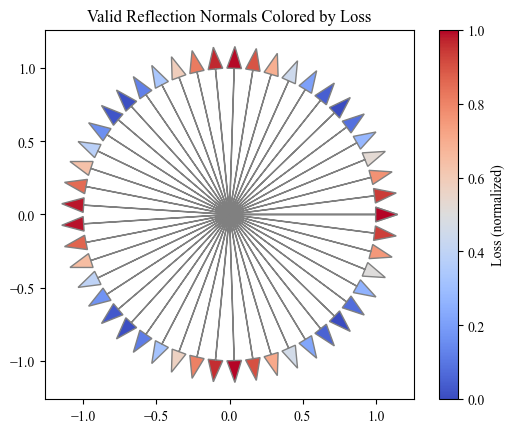

In [8]:
# Memorize current parameter values
old_parameter_values = network.trainable_variables[0].value.numpy()

# 1. Generate angles from 0 to 2*pi
theta = np.linspace(0, 2 * np.pi, 50) # 200 points for a smooth circle

# 2. Calculate x and y coordinates (radius is 1 for a unit circle)
x = np.cos(theta)
y = np.sin(theta)

L = np.zeros(len(x))
for i,x_i,y_i in zip(range(len(x)), x,y):
    network.trainable_variables[0].assign([[x_i, y_i]])
    L[i] = network.compute_loss(data=(Z_ab, Y_ab))

L = (L-np.min(L))/ np.max(L-np.min(L))

# Restore old parameter values
network.trainable_variables[0].assign(old_parameter_values)

# Plot
plt.figure(); plt.title("Valid Reflection Normals Colored by Loss")
plt.scatter(x,y,c=L, colorizer=mpl.colorizer.Colorizer('coolwarm'), s=0.1)
for i in range(len(theta)): plt.arrow(0, 0, x[i], y[i], head_width=0.1, facecolor=mpl.colormaps['coolwarm'](L[i]), edgecolor='grey')
plt.colorbar(label='Loss (normalized)')
plt.gca().set_aspect('equal')


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - Train Loss: 1.9699


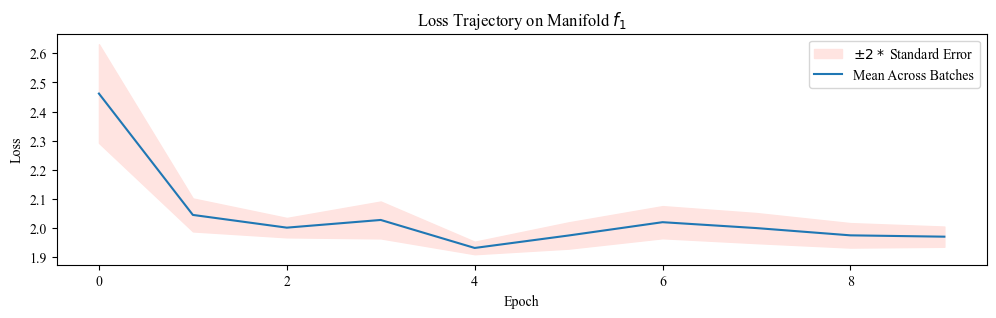

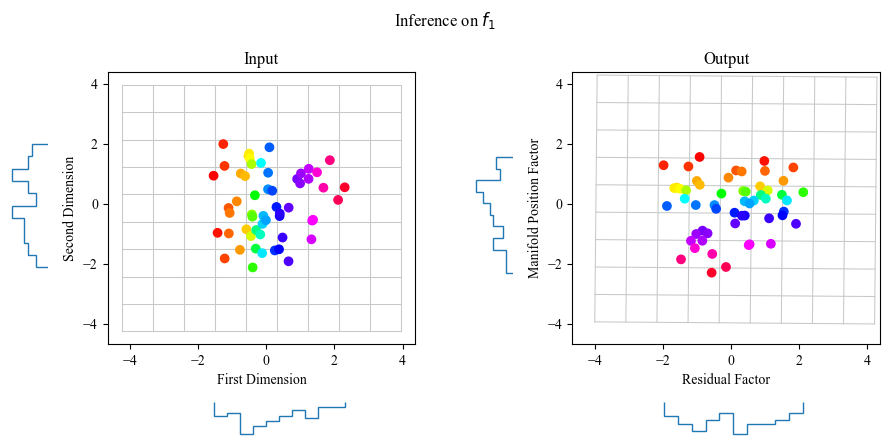

Variable path:  reflection_1/reflection_normals
Variable value:  [[-0.71009247 -0.70410827]]  (optimized parameters)


In [ ]:
# Calibrate network
learning_rate = 0.01
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
batch_size = M//8 # There will be 8 cross validation folds, so M//8 prevents lossing data on partial batches
epoch_count = 10
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
gtp.plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)


## Evaluation

In [ ]:

# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)

# Check scaling parameters after optimization
print("Variable path: ", network.trainable_variables[0].path)
print("Variable value: ", network.trainable_variables[0].value.numpy(), " (optimized parameters)")

In [ ]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab)